In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%cd ..

/mnt/d/anomaly-detection


In [3]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [4]:
window_length = 64
stride = 0

X = np.array([
    data.iloc[i - window_length:i].to_numpy().flatten()
    for i in range(window_length, data.shape[0] - window_length - stride)
]).reshape(-1, window_length, data.shape[1])

Checking on one-dimensional input

In [5]:
from src.models.autoencoder import build_matrix_autoencoder
import keras

build_params = dict(
    input_length=data.shape[1],
    input_shape=window_length,
    layers_size=[32, 32, window_length],
    optimizer=keras.optimizers.Adam(lr=0.01),
    reg_strength=0.005,
)

fit_params = dict(
    batch_size=64,
    epochs=10,
    verbose=1,
    callbacks=[keras.callbacks.ReduceLROnPlateau()]
)

model_fn = lambda: build_matrix_autoencoder(**build_params)

Using TensorFlow backend.


In [6]:
from sklearn.model_selection import TimeSeriesSplit

tssplit = TimeSeriesSplit(n_splits=3)
results = []

for i, (train_idx, test_idx) in enumerate(tssplit.split(X, X)):
    print(f'Fold {i}...')
    model = model_fn()

    squeeze = lambda els: list(map(lambda el: el.squeeze(), els))
    X_tr = squeeze(np.dsplit(X[train_idx], X.shape[2]))
    X_val = squeeze(np.dsplit(X[test_idx], X.shape[2]))
    
    
    history = model.fit(X_tr,
                        X_tr,
                        validation_data=(X_val, X_val),
                        **fit_params)
    results.append(history.history)

W0909 20:15:56.925655 140107742971712 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 20:15:56.928108 140107742971712 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 20:15:56.969385 140107742971712 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0909 20:15:56.984531 140107742971712 deprecation.py:506] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with ke

Fold 0...


W0909 20:16:00.522755 140107742971712 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0909 20:16:06.153074 140107742971712 deprecation_wrapper.py:119] From /home/elch10/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3169 samples, validate on 3168 samples
Epoch 1/10
3169/3169 [==============================] - 13s 4ms/step - loss: 24.1074 - sequential_1_loss: 0.1867 - sequential_2_loss: 0.8564 - sequential_3_loss: 0.6124 - sequential_4_loss: 0.2644 - sequential_5_loss: 0.2189 - sequential_6_loss: 0.2327 - sequential_7_loss: 0.2294 - sequential_8_loss: 0.4945 - sequential_9_loss: 0.7435 - sequential_10_loss: 0.1770 - sequential_11_loss: 0.1480 - sequential_12_loss: 0.2976 - sequential_13_loss: 0.1994 - sequential_14_loss: 0.3094 - sequential_15_loss: 0.1561 - sequential_16_loss: 0.2230 - sequential_17_loss: 0.7835 - sequential_18_loss: 0.1536 - sequential_19_loss: 0.8139 - sequential_20_loss: 0.1631 - sequential_21_loss: 0.1947 - sequential_22_loss: 0.1570 - sequential_23_loss: 0.1756 - sequential_24_loss: 0.1220 - sequential_25_loss: 0.1446 - sequential_26_loss: 0.3570 - sequential_27_loss: 0.2912 - sequential_28_loss: 0.1049 - sequential_29_loss: 0.1834 - sequential_30_loss: 0.1221 - sequ

3169/3169 [==============================] - 1s 411us/step - loss: 10.9304 - sequential_1_loss: 0.0287 - sequential_2_loss: 0.8358 - sequential_3_loss: 0.5938 - sequential_4_loss: 0.1568 - sequential_5_loss: 0.1021 - sequential_6_loss: 0.1077 - sequential_7_loss: 0.0670 - sequential_8_loss: 0.4526 - sequential_9_loss: 0.7065 - sequential_10_loss: 0.0514 - sequential_11_loss: 0.0372 - sequential_12_loss: 0.2365 - sequential_13_loss: 0.0655 - sequential_14_loss: 0.2554 - sequential_15_loss: 0.0741 - sequential_16_loss: 0.0627 - sequential_17_loss: 0.7925 - sequential_18_loss: 0.0241 - sequential_19_loss: 0.8001 - sequential_20_loss: 0.0301 - sequential_21_loss: 0.0615 - sequential_22_loss: 0.0390 - sequential_23_loss: 0.0505 - sequential_24_loss: 0.0802 - sequential_25_loss: 0.0412 - sequential_26_loss: 0.1913 - sequential_27_loss: 0.1481 - sequential_28_loss: 0.0476 - sequential_29_loss: 0.0397 - sequential_30_loss: 0.0686 - sequential_31_loss: 0.0330 - sequential_32_loss: 0.2419 - sequ

3169/3169 [==============================] - 1s 397us/step - loss: 10.9047 - sequential_1_loss: 0.0334 - sequential_2_loss: 0.8363 - sequential_3_loss: 0.5919 - sequential_4_loss: 0.1578 - sequential_5_loss: 0.0996 - sequential_6_loss: 0.1062 - sequential_7_loss: 0.0640 - sequential_8_loss: 0.4543 - sequential_9_loss: 0.7093 - sequential_10_loss: 0.0459 - sequential_11_loss: 0.0343 - sequential_12_loss: 0.2387 - sequential_13_loss: 0.0663 - sequential_14_loss: 0.2568 - sequential_15_loss: 0.0758 - sequential_16_loss: 0.0635 - sequential_17_loss: 0.7937 - sequential_18_loss: 0.0261 - sequential_19_loss: 0.7999 - sequential_20_loss: 0.0295 - sequential_21_loss: 0.0556 - sequential_22_loss: 0.0364 - sequential_23_loss: 0.0470 - sequential_24_loss: 0.0791 - sequential_25_loss: 0.0419 - sequential_26_loss: 0.1925 - sequential_27_loss: 0.1451 - sequential_28_loss: 0.0472 - sequential_29_loss: 0.0414 - sequential_30_loss: 0.0661 - sequential_31_loss: 0.0340 - sequential_32_loss: 0.2399 - sequ

3169/3169 [==============================] - 1s 413us/step - loss: 10.8943 - sequential_1_loss: 0.0340 - sequential_2_loss: 0.8376 - sequential_3_loss: 0.5926 - sequential_4_loss: 0.1506 - sequential_5_loss: 0.0990 - sequential_6_loss: 0.1105 - sequential_7_loss: 0.0611 - sequential_8_loss: 0.4533 - sequential_9_loss: 0.7054 - sequential_10_loss: 0.0476 - sequential_11_loss: 0.0309 - sequential_12_loss: 0.2398 - sequential_13_loss: 0.0628 - sequential_14_loss: 0.2591 - sequential_15_loss: 0.0773 - sequential_16_loss: 0.0616 - sequential_17_loss: 0.7947 - sequential_18_loss: 0.0257 - sequential_19_loss: 0.7987 - sequential_20_loss: 0.0292 - sequential_21_loss: 0.0587 - sequential_22_loss: 0.0395 - sequential_23_loss: 0.0466 - sequential_24_loss: 0.0783 - sequential_25_loss: 0.0452 - sequential_26_loss: 0.1913 - sequential_27_loss: 0.1441 - sequential_28_loss: 0.0475 - sequential_29_loss: 0.0376 - sequential_30_loss: 0.0667 - sequential_31_loss: 0.0360 - sequential_32_loss: 0.2417 - sequ

6337/6337 [==============================] - 3s 405us/step - loss: 11.9417 - sequential_42_loss: 0.0264 - sequential_43_loss: 0.8600 - sequential_44_loss: 0.5977 - sequential_45_loss: 0.1531 - sequential_46_loss: 0.1104 - sequential_47_loss: 0.1184 - sequential_48_loss: 0.0946 - sequential_49_loss: 0.4678 - sequential_50_loss: 0.7104 - sequential_51_loss: 0.0452 - sequential_52_loss: 0.0381 - sequential_53_loss: 0.2442 - sequential_54_loss: 0.0927 - sequential_55_loss: 0.2612 - sequential_56_loss: 0.0990 - sequential_57_loss: 0.0920 - sequential_58_loss: 0.8346 - sequential_59_loss: 0.0316 - sequential_60_loss: 0.8252 - sequential_61_loss: 0.0386 - sequential_62_loss: 0.0735 - sequential_63_loss: 0.0442 - sequential_64_loss: 0.0572 - sequential_65_loss: 0.1027 - sequential_66_loss: 0.0518 - sequential_67_loss: 0.2171 - sequential_68_loss: 0.1851 - sequential_69_loss: 0.0543 - sequential_70_loss: 0.0458 - sequential_71_loss: 0.0911 - sequential_72_loss: 0.0502 - sequential_73_loss: 0.26

6337/6337 [==============================] - 3s 400us/step - loss: 11.8543 - sequential_42_loss: 0.0276 - sequential_43_loss: 0.8576 - sequential_44_loss: 0.5992 - sequential_45_loss: 0.1487 - sequential_46_loss: 0.1091 - sequential_47_loss: 0.1100 - sequential_48_loss: 0.1290 - sequential_49_loss: 0.4557 - sequential_50_loss: 0.7139 - sequential_51_loss: 0.0481 - sequential_52_loss: 0.0389 - sequential_53_loss: 0.2378 - sequential_54_loss: 0.0897 - sequential_55_loss: 0.2580 - sequential_56_loss: 0.0944 - sequential_57_loss: 0.1012 - sequential_58_loss: 0.8473 - sequential_59_loss: 0.0273 - sequential_60_loss: 0.8224 - sequential_61_loss: 0.0317 - sequential_62_loss: 0.0649 - sequential_63_loss: 0.0389 - sequential_64_loss: 0.0491 - sequential_65_loss: 0.1004 - sequential_66_loss: 0.0566 - sequential_67_loss: 0.2081 - sequential_68_loss: 0.1799 - sequential_69_loss: 0.0552 - sequential_70_loss: 0.0411 - sequential_71_loss: 0.0829 - sequential_72_loss: 0.0501 - sequential_73_loss: 0.26

6337/6337 [==============================] - 2s 376us/step - loss: 11.6459 - sequential_42_loss: 0.0216 - sequential_43_loss: 0.8549 - sequential_44_loss: 0.5961 - sequential_45_loss: 0.1463 - sequential_46_loss: 0.1047 - sequential_47_loss: 0.1078 - sequential_48_loss: 0.0707 - sequential_49_loss: 0.4576 - sequential_50_loss: 0.7102 - sequential_51_loss: 0.0371 - sequential_52_loss: 0.0353 - sequential_53_loss: 0.2392 - sequential_54_loss: 0.0775 - sequential_55_loss: 0.2544 - sequential_56_loss: 0.0973 - sequential_57_loss: 0.0781 - sequential_58_loss: 0.8420 - sequential_59_loss: 0.0277 - sequential_60_loss: 0.8221 - sequential_61_loss: 0.0300 - sequential_62_loss: 0.0640 - sequential_63_loss: 0.0392 - sequential_64_loss: 0.0473 - sequential_65_loss: 0.0931 - sequential_66_loss: 0.0449 - sequential_67_loss: 0.2061 - sequential_68_loss: 0.1756 - sequential_69_loss: 0.0534 - sequential_70_loss: 0.0389 - sequential_71_loss: 0.0801 - sequential_72_loss: 0.0428 - sequential_73_loss: 0.26

9505/9505 [==============================] - 4s 375us/step - loss: 11.6953 - sequential_83_loss: 0.0264 - sequential_84_loss: 0.8430 - sequential_85_loss: 0.5968 - sequential_86_loss: 0.1477 - sequential_87_loss: 0.1052 - sequential_88_loss: 0.1126 - sequential_89_loss: 0.0901 - sequential_90_loss: 0.4566 - sequential_91_loss: 0.7061 - sequential_92_loss: 0.0478 - sequential_93_loss: 0.0399 - sequential_94_loss: 0.2417 - sequential_95_loss: 0.0923 - sequential_96_loss: 0.2607 - sequential_97_loss: 0.0984 - sequential_98_loss: 0.0885 - sequential_99_loss: 0.8411 - sequential_100_loss: 0.0278 - sequential_101_loss: 0.8362 - sequential_102_loss: 0.0318 - sequential_103_loss: 0.0646 - sequential_104_loss: 0.0429 - sequential_105_loss: 0.0486 - sequential_106_loss: 0.0991 - sequential_107_loss: 0.0465 - sequential_108_loss: 0.2091 - sequential_109_loss: 0.2114 - sequential_110_loss: 0.0540 - sequential_111_loss: 0.0415 - sequential_112_loss: 0.0828 - sequential_113_loss: 0.0436 - sequential

9505/9505 [==============================] - 4s 391us/step - loss: 11.4696 - sequential_83_loss: 0.0208 - sequential_84_loss: 0.8387 - sequential_85_loss: 0.5912 - sequential_86_loss: 0.1435 - sequential_87_loss: 0.1018 - sequential_88_loss: 0.1064 - sequential_89_loss: 0.0780 - sequential_90_loss: 0.4519 - sequential_91_loss: 0.7000 - sequential_92_loss: 0.0420 - sequential_93_loss: 0.0340 - sequential_94_loss: 0.2382 - sequential_95_loss: 0.0755 - sequential_96_loss: 0.2588 - sequential_97_loss: 0.0902 - sequential_98_loss: 0.0738 - sequential_99_loss: 0.8379 - sequential_100_loss: 0.0257 - sequential_101_loss: 0.8339 - sequential_102_loss: 0.0276 - sequential_103_loss: 0.0598 - sequential_104_loss: 0.0370 - sequential_105_loss: 0.0460 - sequential_106_loss: 0.0948 - sequential_107_loss: 0.0439 - sequential_108_loss: 0.1991 - sequential_109_loss: 0.2021 - sequential_110_loss: 0.0563 - sequential_111_loss: 0.0388 - sequential_112_loss: 0.0774 - sequential_113_loss: 0.0391 - sequential

9505/9505 [==============================] - 4s 417us/step - loss: 11.4319 - sequential_83_loss: 0.0207 - sequential_84_loss: 0.8380 - sequential_85_loss: 0.5899 - sequential_86_loss: 0.1431 - sequential_87_loss: 0.1005 - sequential_88_loss: 0.1050 - sequential_89_loss: 0.0754 - sequential_90_loss: 0.4510 - sequential_91_loss: 0.7000 - sequential_92_loss: 0.0380 - sequential_93_loss: 0.0348 - sequential_94_loss: 0.2372 - sequential_95_loss: 0.0715 - sequential_96_loss: 0.2571 - sequential_97_loss: 0.0930 - sequential_98_loss: 0.0717 - sequential_99_loss: 0.8364 - sequential_100_loss: 0.0262 - sequential_101_loss: 0.8335 - sequential_102_loss: 0.0293 - sequential_103_loss: 0.0561 - sequential_104_loss: 0.0379 - sequential_105_loss: 0.0445 - sequential_106_loss: 0.0932 - sequential_107_loss: 0.0421 - sequential_108_loss: 0.1973 - sequential_109_loss: 0.2007 - sequential_110_loss: 0.0525 - sequential_111_loss: 0.0377 - sequential_112_loss: 0.0794 - sequential_113_loss: 0.0379 - sequential

In [7]:
# results = cross_validate(lambda: build_autoencoder(**build_params), 3, fit_params, X[:, :, 0], X[:, :, 0])

In [8]:
??build_matrix_autoencoder

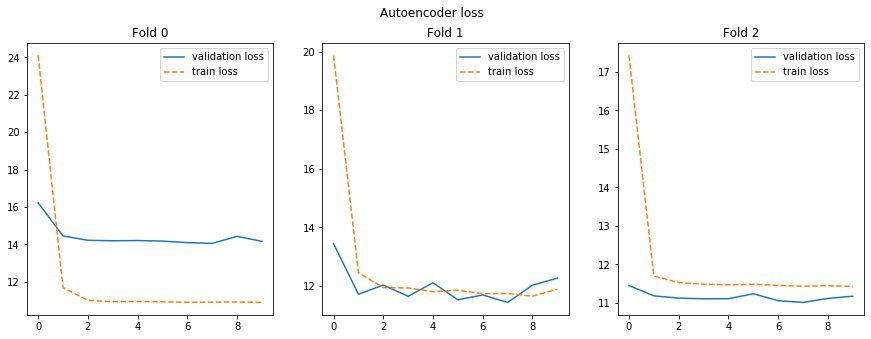

In [9]:
from src.visualization.visualize import visualize_result
visualize_result(results, f'Autoencoder loss')